<a href="https://www.kaggle.com/code/tornikeonoprishvili/fdtd-meep-ez-simulation?scriptVersionId=97737923" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!conda install -y -c conda-forge pymeep pymeep-extras seaborn

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pymeep
    - pymeep-extras
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    aom-3.3.0                  |       h27087fc_1         2.6 MB  conda-forge
    autograd-1.3               |             py_0          39 KB  conda-forge
    cached-property-1.5.2      |       hd8ed1ab_1           4 KB  conda-forge
    cached_property-1.5.2      |     pyha770c72_1          11 KB  conda-forge

In [2]:
%load_ext autoreload
%autoreload 2

import meep as mp
from tqdm import tqdm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math 
import seaborn as sns
from itertools import product
from math import pi
from functools import partial
import os
import copy

print(mpl.__version__)

3.5.2


## Fields in a waveguide

1) ერთი ვორტიქსის სიგრძე, ანუ ჩვენს შემთხვევაში კვადრატის სიგრძე, ანუ h არის დაახლოვებით 10 ნანომეტრი.

2) Q პარამეტრი დაივიწყეთ. რაც გვიწერია სტატიაში omega/c*Q ეს იგივეა რაც h/lambda. lambda კი თავის მხრივ სიხშირეზეა დამოკიდებული.
თუ მაგალითად აიღებთ ჩვენს შემთხვევაში როგორც ჩვენის შედეგების ნახაზზეა, მაგალითად, განუზომელ პარამეტრს 0.53, ეს ნიშნავს, რომ h/lambda=0.53
ანუ თუ ვიცით, რომ  h=10 ნმ, ესეიგი ლამბდა არის 10/0.53=18.8679 ნმ. შესაბამისად შეგიძლიათ აქედან გაიგოთ სიხშირე, თუმცა არ მგონია რომ
სიხშირის გაგება გჭირდებოდეთ, მგონია რომ პერიოდი და ტალღის სიგრძე საკმარისია. 

ჯერ ნახეთ  h/lambda=0.53 და  h/lambda=0.58, სადაც ნამდვილად გასვლა გვაქვს. ამას იმიტომ ვამბობ, რომ არეკვლის სიმძლავრე დამოკიდებულია
ფენების რაოდენომაზე (როგორც ფოტონიკებში გვქონდა, 5-ს რომ ვიღებდით), შესაბამისად მე უნდა დავთვალო თქვენ რამდენ ფენასაც აიღებთ იქ
რამდენად ძლიერი იქნება არეკვლა. არეკვლა რომ იქნება ცხადია, თუმცა რამდენად ძლიერი, შეიძლება ნაწილი გავიდეს. 
რაც შეეხება h/lambda=0.53 და  h/lambda=0.58 აქ სრული გასვლაა და პრობლემა არ არის. 

მარტივია, მაგრამ მაინც იხილეთ ბმული ფაილი. ამ მარტივი გარდაქმნით პირდაპირ გამოდის 9.21 ფორმულა.
ანუ დროით ორმაგი წარმოებულები ჩაწერილი ამ ფორმით. აქედან პირდაპი 9.21.
თუ ახლა, უბრალოდ შესამოწმებლად, დაუშვებთ რომ ომეგა_დ=0 (გამმა_დ ყოველთვის ნულია ჩვენთან რადგანაც მილევა არ გვაქვს),
მიიღებთ დროის ყველა ეტაპზე ცნობილ დამოკიდებულებას D და E ვექტორებს შორის, კერძოდ D=eps_0*eps*E.
მოკლედ მე თითქმის დარწმუნებული ვარ, რომ თუ თქვენ სწორედ 
გამოიყენებთ ამ 9.21 ფორმულას, უნდა გადაიჭრას ჩვენი პრობლემა. ასევე ყურადღება მიაქციეთ სულ ბოლო წინადადებას
გაყვითლებული რომ მაქვს, სადაც რეალურად წერია რა მონაცემებით უნდა გააკეთოთ "აპდეითი" ახალი მონაცემების.
მოკლედ ერთი დამეტებითი D ვექტორის შემოტანა მოგიწევთ.


In [3]:
def draw_geometry(source_wavelength, empty_space=False, vortex = False):
    vortex_rads = np.zeros((6,6))
    d = 3
    for val in [pi * 1.5, pi, pi * .5, 0]:
        for x,y in product(range(6), range(6)):
            if y - d >= abs(x - d): 
                vortex_rads[x,y] = val
        vortex_rads = np.rot90(vortex_rads)
    W,H, _ = grid_size
    D = pml_depth

    sources = [
        mp.Source(
            mp.ContinuousSource(wavelength=source_wavelength,width=100),
            component=polarization, #  NOTE: Direction matters!
            size=mp.Vector3((W - D * 2) * .7 , 0, 0),
            center=mp.Vector3(0, H/2 - D - h * .5, 0)
        )
    ]
    pml_layers = [mp.PML(pml_size)]
    
    geometry = []
    def make_eps_function_at(center, size):
        bins = np.linspace([-size.x/2,-size.y/2],[+size.x/2, +size.y/2],7)
        def eps_function(p):
            x,y = p.x - center.x, p.y - center.y
            x = np.digitize(x,bins[:,0],right=False)
            y = np.digitize(y,bins[:,1],right=False)
            x = np.clip(x, 1, 6) - 1
            y = np.clip(y, 1, 6) - 1
            eps_1 = 1 + k_0 * np.sin(vortex_rads[x,y]) ** 2 # first eps (for Ex)
            eps_3 = 1 + k_0 * np.cos(vortex_rads[x,y]) ** 2 # middle eps (for Ey)
            eps_4 = 1 # last eps (For Ez)
            return mp.Medium(epsilon_diag=(eps_1, eps_3, eps_4))
        return eps_function
    
    if not empty_space:
        for row in range(vortex_rows):
            for col in range(vortex_cols):
                if row % 2 == 0: # Leave out air between rows
                    size = mp.Vector3(h,h,mp.inf)
                    center = mp.Vector3(
                        x=D + h / 2 + col * h - W / 2,
                        y=D + h * 1.5 + row * h - H / 2, 
                        z=0
                    )
                    if vortex:
                        material = make_eps_function_at(center, size)
                    else:
                        material = mp.Medium(epsilon=1 + k_0)
                    bl = mp.Block(
                        size=size,
                        center=center,
                        material=material
                    )
                    geometry.append(bl)
    return geometry, sources, pml_layers

In [4]:
def simulate(ratio = 0.21, 
             n_slabs = 24, 
             polarization = mp.Ez,
             vortex = False, 
             empty_sim = False,
             angle_d = 0,
            ):
    # scale is nanometers
    # unit of distance is 1nm
#     ratio = 0.21 # Should block on both 12 and 24
#     polarization=mp.Ez
    vortex_rows = n_slabs * 2
    vortex_cols = vortex_rows // 2 # At least 2:1 ratio is needed

    width = 1 # h

    h = 1 # nanometers
    lamd = h / ratio # nanometers
    k_0 = - 0.01 * ((h/lamd) ** (-2)) # Used for eps hat calculation
    min_eps = 1 + min( +k_0, -k_0 )
    
    if vortex:
        min_px_per_h = 12
    else: 
        min_px_per_h = 6
    
    resolution = math.ceil(max(1 / (lamd / 10), 1 / (h / min_px_per_h)))
    size_of_pixel = 1 / resolution

    pml_size = lamd * 0.50
    pml_depth = math.ceil(pml_size) # nm

    simulation_area = np.array([vortex_cols * h, (vortex_rows + 1) * h, 0])
    grid_size = simulation_area + [pml_depth * 2, pml_depth * 2, 0] # nm

    courant_factor = 0.9
    courant = courant_factor * (abs(min_eps) ** .5) / (2 ** .5)
    time_resolution = courant_factor * size_of_pixel
    
    # this is pixels per scale (nanometers here). 
    # The vortices have size 10nmx10nm, and consist of 
    # 6x6 cells. So, the resolution should be

    
    cell = mp.Vector3(*grid_size) / 1.
    W,H, _ = grid_size
    
    print(f'Resolution is {resolution} per h, k_0 is {k_0:.5f}, min_eps {min_eps}')    
    print(f'Grid size NU: {cell}, PX: {cell * resolution}')

#     geometry, sources, pml_layers = draw_geometry(
#         source_wavelength=lamd,
#         empty_space=empty_sim,
#         vortex= vortex)
    vortex_rads = np.zeros((6,6))
    d = 3
    for val in [pi * 1.5, pi, pi * .5, 0]:
        for x,y in product(range(6), range(6)):
            if y - d >= abs(x - d): 
                vortex_rads[x,y] = val
        vortex_rads = np.rot90(vortex_rads)
        
    W,H, _ = grid_size
    D = pml_depth

    sources = [
        mp.Source(
            mp.ContinuousSource(wavelength=lamd,width=100),
            component=polarization, #  NOTE: Direction matters!
            size=mp.Vector3((W - D * 2) * .7 , 0, 0),
            center=mp.Vector3(0, H/2 - D - h * .5, 0)
        )
    ]
    pml_layers = [mp.PML(pml_size)]
    
    geometry = []
    def make_eps_function_at(center, size):
        bins = np.linspace([-size.x/2,-size.y/2],[+size.x/2, +size.y/2],7)
        def eps_function(p):
            x,y = p.x - center.x, p.y - center.y
            x = np.digitize(x,bins[:,0],right=False)
            y = np.digitize(y,bins[:,1],right=False)
            x = np.clip(x, 1, 6) - 1
            y = np.clip(y, 1, 6) - 1
            eps_1 = 1 + k_0 * np.sin(vortex_rads[x,y]) ** 2 # first eps (for Ex)
            eps_3 = 1 + k_0 * np.cos(vortex_rads[x,y]) ** 2 # middle eps (for Ey)
            eps_4 = 1 # last eps (For Ez)
            return mp.Medium(epsilon_diag=(eps_1, eps_3, eps_4))
        return eps_function
    
    if not empty_sim:
        for row in range(vortex_rows):
            for col in range(vortex_cols):
                if row % 2 == 0: # Leave out air between rows
                    size = mp.Vector3(h,h,mp.inf)
                    center = mp.Vector3(
                        x=D + h / 2 + col * h - W / 2,
                        y=D + h * 1.5 + row * h - H / 2, 
                        z=0
                    )
                    if vortex:
                        material = make_eps_function_at(center, size)
                    else:
                        material = mp.Medium(epsilon=1 + k_0)
                    bl = mp.Block(
                        size=size,
                        center=center,
                        material=material
                    )
                    geometry.append(bl)
    
    sim = mp.Simulation(
        cell_size=cell,
        boundary_layers=pml_layers,
        geometry=geometry,
        geometry_center=mp.Vector3(0,0,0),
        sources=sources,
        resolution=resolution,
        Courant=courant,
    )
    
    sim.init_sim()
    eps_grid = sim.get_epsilon()
#     plt.figure(figsize=(15,7))
#     plt.imshow(z)
#     plt.colorbar()
#     os.makedirs('media', exist_ok=True)
#     plt.savefig("media/eps_map.png")
    
    
    vals = []
    
    def get_slice(sim):
        vals.append(
            sim.get_array(
                center=mp.Vector3(0,0,0), 
                size=mp.Vector3(0,H,0),
                component=polarization
            )
        )
        
    sim.run(
        # mp.to_appended("hz",mp.at_every(4, mp.output_hfield_z)),
        mp.at_every(998, get_slice),
        until=1000,
    )
    
#     plt.figure(figsize=(15,5))
#     plt.subplot(121)
#     plt.plot(vals[1])
#     plt.title(f'Ratio {ratio} with {vortex_rows // 2} row structure')
    
#     plt.subplot(122)
#     sim.plot2D()
#     plt.title('Grid')
#     plt.show()

#     sim.reset_meep()
#     tmp = locals()
#     loc_copy = {}
#     for name,val in tmp.items():
#         loc_copy[name] = copy.copy(val)
#     return loc_copy
    return locals()

In [5]:
res = simulate(0.26, empty_sim=False)
res2 = simulate(0.26, empty_sim=True)

Resolution is 6 per h, k_0 is -0.14793, min_eps 0.8520710059171598
Grid size NU: Vector3<28.0, 53.0, 0.0>, PX: Vector3<168.0, 318.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.00367713 s
Working in 2D dimensions.
Computational cell is 28 x 53 x 0 with resolution 6
     block, center = (-11.5,-23,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.852071,0.852071,0.852071)
     block, center = (-10.5,-23,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.852071,0.852071,0.852071)
     block, center = (-9.5,-23,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.852071,0.852071,0.852071)
     block, center = (-8.5,-23,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.85207

/opt/conda/lib/python3.7/site-packages/meep/simulation.py:2041: RuntimeWarning: Epsilon < 1 may require adjusting the Courant parameter. See the 'Numerical Stability' entry under the 'Materials' section of the documentation
  warnings.warn(eps_warning, RuntimeWarning)


time for set_epsilon = 0.320975 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 980.3437200028939/1000.0 = 98.0% done in 4.0s, 0.1s to go
on time step 10031 (time=982.106), 0.000398786 s/step
run 0 finished at t = 1000.0230456516088 (10214 timesteps)
Resolution is 6 per h, k_0 is -0.14793, min_eps 0.8520710059171598
Grid size NU: Vector3<28.0, 53.0, 0.0>, PX: Vector3<168.0, 318.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.00022006 s
Working in 2D dimensions.
Computational cell is 28 x 53 x 0 with resolution 6
time for set_epsilon = 0.080462 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 995.127691012625/1000.0 = 99.5% done in 4.0s, 0.0s to go
on time step 10181 (time=996.792), 0.000392905 s/step
run 0 finished at t = 1000.0230456516088 (10214 timesteps)


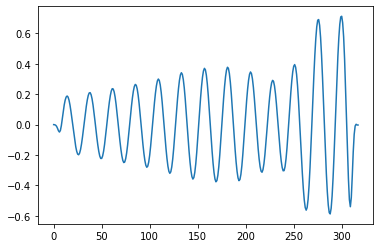

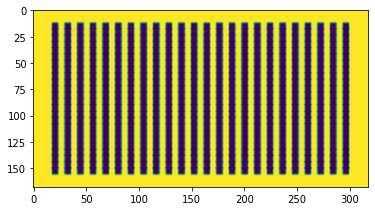

In [6]:
plt.plot(res['vals'][0])
plt.figure()
plt.imshow(res['eps_grid'])

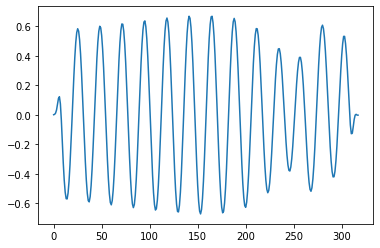

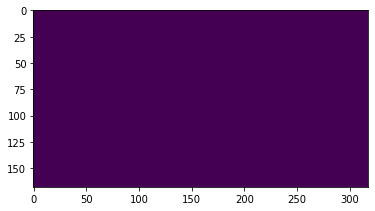

In [7]:
plt.plot(res2['vals'][0])
plt.figure()
plt.imshow(res2['eps_grid'])

In [8]:
results = {}
for r in tqdm(np.arange(0.21,0.34,0.01)):
    for rows in [32]:
        for empty_sim in [True, False]:
            results[(r,rows,empty_sim)] = simulate(
                    ratio = r, 
                    n_slabs = rows, 
                    polarization = mp.Ez,
                    vortex = False, 
                    empty_sim = empty_sim,
                    angle_d = 0,
                )

  0%|          | 0/14 [00:00<?, ?it/s]

Resolution is 6 per h, k_0 is -0.22676, min_eps 0.7732426303854875
Grid size NU: Vector3<38.0, 71.0, 0.0>, PX: Vector3<228.0, 426.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247955 s
Working in 2D dimensions.
Computational cell is 38 x 71 x 0 with resolution 6
time for set_epsilon = 0.140482 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 598.316275421013/1000.0 = 59.8% done in 4.0s, 2.7s to go
on time step 6426 (time=599.342), 0.000622548 s/step
run 0 finished at t = 1000.0229314207484 (10722 timesteps)
Resolution is 6 per h, k_0 is -0.22676, min_eps 0.7732426303854875
Grid size NU: Vector3<38.0, 71.0, 0.0>, PX: Vector3<228.0, 426.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.00508189 s
Working in 2D dimensions.
Computational cell is 38 x 71 x 0 with resolution 6
     block, center = (-15.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.773243,0.773243,0.773243)
     block, center = (-14.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.773243,0.773243,0.773243)
     block, center = (-13.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 566.1387048800543/1000.0 = 56.6% done in 4.0s, 3.1s to go
on time step 6080 (time=567.071), 0.000657922 s/step


  7%|▋         | 1/14 [00:14<03:08, 14.48s/it]

run 0 finished at t = 1000.0229314207484 (10722 timesteps)
Resolution is 6 per h, k_0 is -0.20661, min_eps 0.793388429752066
Grid size NU: Vector3<38.0, 71.0, 0.0>, PX: Vector3<228.0, 426.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.000213146 s
Working in 2D dimensions.
Computational cell is 38 x 71 x 0 with resolution 6
time for set_epsilon = 0.14391 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 641.1107334634037/1000.0 = 64.1% done in 4.0s, 2.2s to go
on time step 6801 (time=642.528), 0.000588228 s/step
run 0 finished at t = 1000.0231526245399 (10585 timesteps)
Resolution is 6 per h, k_0 is -0.20661, min_eps 0.793388429752066
Grid size NU: Vector3<38.0, 71.0, 0.0>, PX: Vector3<228.0, 426.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.00515103 s
Working in 2D dimensions.
Computational cell is 38 x 71 x 0 with resolution 6
     block, center = (-15.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.793388,0.793388,0.793388)
     block, center = (-14.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.793388,0.793388,0.793388)
     block, center = (-13.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 570.3485850159988/1000.0 = 57.0% done in 4.0s, 3.0s to go
on time step 6050 (time=571.577), 0.000661252 s/step


 14%|█▍        | 2/14 [00:28<02:51, 14.29s/it]

run 0 finished at t = 1000.0231526245399 (10585 timesteps)
Resolution is 6 per h, k_0 is -0.18904, min_eps 0.8109640831758034
Grid size NU: Vector3<38.0, 71.0, 0.0>, PX: Vector3<228.0, 426.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.000337124 s
Working in 2D dimensions.
Computational cell is 38 x 71 x 0 with resolution 6
time for set_epsilon = 0.141368 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 608.0561782961203/1000.0 = 60.8% done in 4.0s, 2.6s to go
on time step 6376 (time=609.011), 0.000627377 s/step
run 0 finished at t = 1000.0546947471535 (10470 timesteps)
Resolution is 6 per h, k_0 is -0.18904, min_eps 0.8109640831758034
Grid size NU: Vector3<38.0, 71.0, 0.0>, PX: Vector3<228.0, 426.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.0055778 s
Working in 2D dimensions.
Computational cell is 38 x 71 x 0 with resolution 6
     block, center = (-15.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.810964,0.810964,0.810964)
     block, center = (-14.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.810964,0.810964,0.810964)
     block, center = (-13.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 565.4559496564611/1000.0 = 56.5% done in 4.0s, 3.1s to go
on time step 5931 (time=566.507), 0.00067458 s/step


 21%|██▏       | 3/14 [00:42<02:37, 14.29s/it]

run 0 finished at t = 1000.0546947471535 (10470 timesteps)
Resolution is 6 per h, k_0 is -0.17361, min_eps 0.826388888888889
Grid size NU: Vector3<38.0, 71.0, 0.0>, PX: Vector3<228.0, 426.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.000306129 s
Working in 2D dimensions.
Computational cell is 38 x 71 x 0 with resolution 6
time for set_epsilon = 0.142757 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 655.5616460691358/1000.0 = 65.6% done in 4.0s, 2.1s to go
on time step 6811 (time=656.719), 0.000587317 s/step
run 0 finished at t = 1000.0713918266035 (10372 timesteps)
Resolution is 6 per h, k_0 is -0.17361, min_eps 0.826388888888889
Grid size NU: Vector3<38.0, 71.0, 0.0>, PX: Vector3<228.0, 426.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.0050528 s
Working in 2D dimensions.
Computational cell is 38 x 71 x 0 with resolution 6
     block, center = (-15.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.826389,0.826389,0.826389)
     block, center = (-14.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.826389,0.826389,0.826389)
     block, center = (-13.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.8

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 591.152883078375/1000.0 = 59.1% done in 4.0s, 2.8s to go
on time step 6142 (time=592.214), 0.000651319 s/step


 29%|██▊       | 4/14 [00:56<02:20, 14.06s/it]

run 0 finished at t = 1000.0713918266035 (10372 timesteps)
Resolution is 6 per h, k_0 is -0.16000, min_eps 0.84
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.00030899 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
time for set_epsilon = 0.132015 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 640.2323735957125/1000.0 = 64.0% done in 4.0s, 2.2s to go
on time step 6597 (time=641.302), 0.000606485 s/step
run 0 finished at t = 1000.0106934678248 (10287 timesteps)
Resolution is 6 per h, k_0 is -0.16000, min_eps 0.84
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.00565314 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
     block, center = (-15.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.84,0.84,0.84)
     block, center = (-14.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.84,0.84,0.84)
     block, center = (-13.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.84,0.84,0.84)
     block, center = (-

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 617.4849737443009/1000.0 = 61.7% done in 4.0s, 2.5s to go
on time step 6365 (time=618.749), 0.000628483 s/step


 36%|███▌      | 5/14 [01:10<02:05, 13.90s/it]

run 0 finished at t = 1000.0106934678248 (10287 timesteps)
Resolution is 6 per h, k_0 is -0.14793, min_eps 0.8520710059171598
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.000296831 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
time for set_epsilon = 0.144506 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 700.8189701169194/1000.0 = 70.1% done in 4.0s, 1.7s to go
on time step 7172 (time=702.19), 0.000557775 s/step
run 0 finished at t = 1000.0230456516088 (10214 timesteps)
Resolution is 6 per h, k_0 is -0.14793, min_eps 0.8520710059171598
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.00573015 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
     block, center = (-15.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.852071,0.852071,0.852071)
     block, center = (-14.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.852071,0.852071,0.852071)
     block, center = (-13.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 653.1382159332173/1000.0 = 65.3% done in 4.0s, 2.1s to go
on time step 6682 (time=654.215), 0.000598705 s/step


 43%|████▎     | 6/14 [01:22<01:48, 13.50s/it]

run 0 finished at t = 1000.0230456516088 (10214 timesteps)
Resolution is 6 per h, k_0 is -0.13717, min_eps 0.8628257887517147
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.000218153 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
time for set_epsilon = 0.129741 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 668.8729431123505/1000.0 = 66.9% done in 4.0s, 2.0s to go
on time step 6803 (time=670.252), 0.00058798 s/step
run 0 finished at t = 1000.0088927073734 (10150 timesteps)
Resolution is 6 per h, k_0 is -0.13717, min_eps 0.8628257887517147
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.00549889 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
     block, center = (-15.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.862826,0.862826,0.862826)
     block, center = (-14.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.862826,0.862826,0.862826)
     block, center = (-13.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 648.1831039528877/1000.0 = 64.8% done in 4.0s, 2.2s to go
on time step 6591 (time=649.365), 0.000606962 s/step


 50%|█████     | 7/14 [01:35<01:33, 13.34s/it]

run 0 finished at t = 1000.0088927073734 (10150 timesteps)
Resolution is 6 per h, k_0 is -0.12755, min_eps 0.8724489795918368
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.000225067 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
time for set_epsilon = 0.137668 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 670.4130464693206/1000.0 = 67.0% done in 4.0s, 2.0s to go
on time step 6782 (time=671.899), 0.000589861 s/step
run 0 finished at t = 1000.0220616316421 (10094 timesteps)
Resolution is 6 per h, k_0 is -0.12755, min_eps 0.8724489795918368
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.0050261 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
     block, center = (-15.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.872449,0.872449,0.872449)
     block, center = (-14.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.872449,0.872449,0.872449)
     block, center = (-13.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 682.7969138859994/1000.0 = 68.3% done in 4.0s, 1.9s to go
on time step 6901 (time=683.689), 0.000579697 s/step


 57%|█████▋    | 8/14 [01:48<01:18, 13.11s/it]

run 0 finished at t = 1000.0220616316421 (10094 timesteps)
Resolution is 6 per h, k_0 is -0.11891, min_eps 0.8810939357907254
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.000200987 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
time for set_epsilon = 0.130141 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 733.4627073108454/1000.0 = 73.3% done in 4.0s, 1.5s to go
on time step 7386 (time=735.354), 0.000541634 s/step
run 0 finished at t = 1000.0859094526188 (10045 timesteps)
Resolution is 6 per h, k_0 is -0.11891, min_eps 0.8810939357907254
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.00670505 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
     block, center = (-15.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.881094,0.881094,0.881094)
     block, center = (-14.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.881094,0.881094,0.881094)
     block, center = (-13.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 685.8727556216119/1000.0 = 68.6% done in 4.0s, 1.8s to go
on time step 6901 (time=687.067), 0.000579658 s/step


 64%|██████▍   | 9/14 [02:00<01:04, 12.85s/it]

run 0 finished at t = 1000.0859094526188 (10045 timesteps)
Resolution is 6 per h, k_0 is -0.11111, min_eps 0.888888888888889
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.000198126 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
time for set_epsilon = 0.128551 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 722.6999999999999/1000.0 = 72.3% done in 4.0s, 1.5s to go
on time step 7241 (time=724.1), 0.000552449 s/step
run 0 finished at t = 999.9999999999999 (10000 timesteps)
Resolution is 6 per h, k_0 is -0.11111, min_eps 0.888888888888889
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.00506711 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
     block, center = (-15.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.888889,0.888889,0.888889)
     block, center = (-14.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.888889,0.888889,0.888889)
     block, center = (-13.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.888

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 657.5/1000.0 = 65.8% done in 4.0s, 2.1s to go
on time step 6585 (time=658.5), 0.00060755 s/step


 71%|███████▏  | 10/14 [02:13<00:50, 12.75s/it]

run 0 finished at t = 999.9999999999999 (10000 timesteps)
Resolution is 6 per h, k_0 is -0.10406, min_eps 0.8959417273673257
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.00030303 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
time for set_epsilon = 0.132842 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 693.8363297890359/1000.0 = 69.4% done in 4.0s, 1.8s to go
on time step 6923 (time=695.041), 0.000577795 s/step
run 0 finished at t = 1000.0439416913017 (9961 timesteps)
Resolution is 6 per h, k_0 is -0.10406, min_eps 0.8959417273673257
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.00504804 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
     block, center = (-15.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.895942,0.895942,0.895942)
     block, center = (-14.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.895942,0.895942,0.895942)
     block, center = (-13.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 759.194085640962/1000.0 = 75.9% done in 4.0s, 1.3s to go
on time step 7575 (time=760.499), 0.000528073 s/step


 79%|███████▊  | 11/14 [02:25<00:37, 12.46s/it]

run 0 finished at t = 1000.0439416913017 (9961 timesteps)
Resolution is 6 per h, k_0 is -0.09766, min_eps 0.90234375
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.000307083 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
time for set_epsilon = 0.130938 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 751.524036824375/1000.0 = 75.2% done in 4.0s, 1.3s to go
on time step 7473 (time=752.935), 0.000535274 s/step
run 0 finished at t = 1000.0841385599607 (9926 timesteps)
Resolution is 6 per h, k_0 is -0.09766, min_eps 0.90234375
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.00524712 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
     block, center = (-15.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.902344,0.902344,0.902344)
     block, center = (-14.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.902344,0.902344,0.902344)
     block, center = (-13.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.902344,0.

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 724.521966591243/1000.0 = 72.5% done in 4.0s, 1.5s to go
on time step 7202 (time=725.63), 0.000555478 s/step


 86%|████████▌ | 12/14 [02:36<00:24, 12.26s/it]

run 0 finished at t = 1000.0841385599607 (9926 timesteps)
Resolution is 6 per h, k_0 is -0.09183, min_eps 0.9081726354453628
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.000206947 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
time for set_epsilon = 0.131218 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 727.0604609338249/1000.0 = 72.7% done in 4.0s, 1.5s to go
on time step 7210 (time=728.779), 0.000554848 s/step
run 0 finished at t = 1000.0745447628615 (9894 timesteps)
Resolution is 6 per h, k_0 is -0.09183, min_eps 0.9081726354453628
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.00512481 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
     block, center = (-15.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.908173,0.908173,0.908173)
     block, center = (-14.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.908173,0.908173,0.908173)
     block, center = (-13.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 656.8106318848872/1000.0 = 65.7% done in 4.0s, 2.1s to go
on time step 6511 (time=658.125), 0.000614539 s/step


 93%|█████████▎| 13/14 [02:49<00:12, 12.33s/it]

run 0 finished at t = 1000.0745447628615 (9894 timesteps)
Resolution is 6 per h, k_0 is -0.08651, min_eps 0.9134948096885813
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.000226021 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
time for set_epsilon = 0.133051 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 745.5090653407177/1000.0 = 74.6% done in 4.0s, 1.4s to go
on time step 7369 (time=747.03), 0.000542872 s/step
run 0 finished at t = 1000.0607736723117 (9865 timesteps)
Resolution is 6 per h, k_0 is -0.08651, min_eps 0.9134948096885813
Grid size NU: Vector3<36.0, 69.0, 0.0>, PX: Vector3<216.0, 414.0, 0.0>
-----------
Initializing structure...
time for choose_chunkdivision = 0.00570607 s
Working in 2D dimensions.
Computational cell is 36 x 69 x 0 with resolution 6
     block, center = (-15.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.913495,0.913495,0.913495)
     block, center = (-14.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.913495,0.913495,0.913495)
     block, center = (-13.5,-31,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.9

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 687.0159009809687/1000.0 = 68.7% done in 4.0s, 1.8s to go
on time step 6787 (time=688.03), 0.000589435 s/step


100%|██████████| 14/14 [03:01<00:00, 12.97s/it]

run 0 finished at t = 1000.0607736723117 (9865 timesteps)


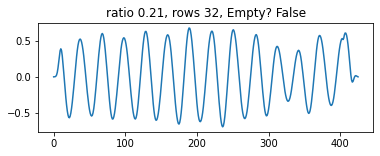

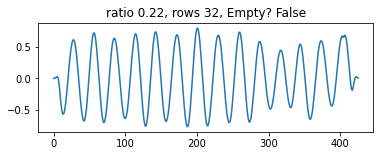

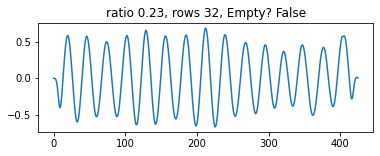

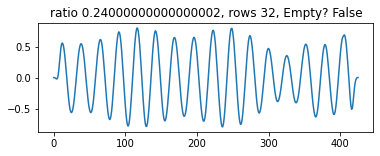

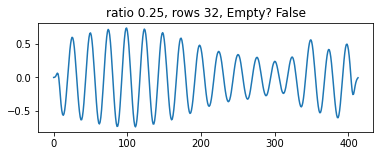

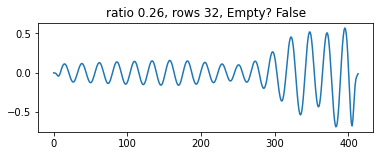

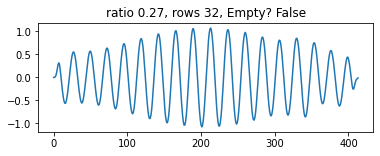

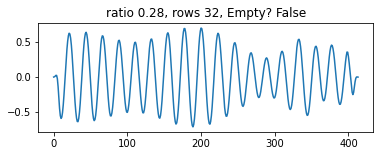

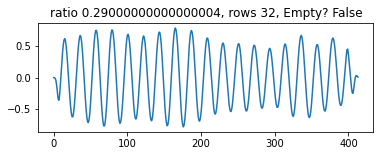

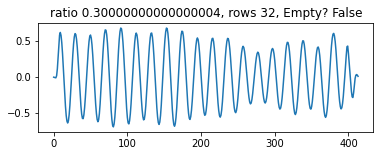

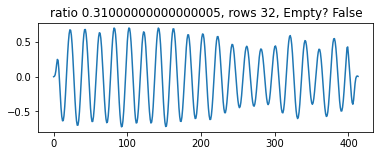

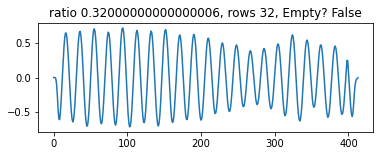

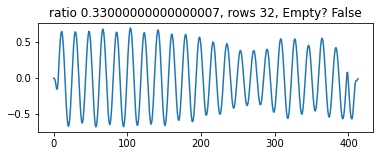

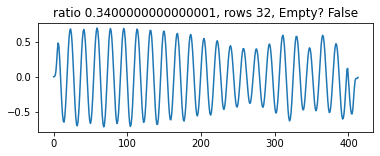

In [9]:
for (r, rows, empty_sim),result in results.items():
    if not empty_sim:
        plt.figure(figsize=(6,2))
        plt.plot(result['vals'][0])
        plt.title(f'ratio {r}, rows {rows}, Empty? {empty_sim}')
        


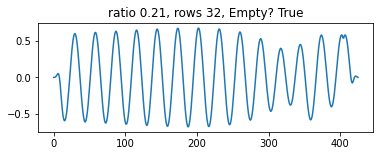

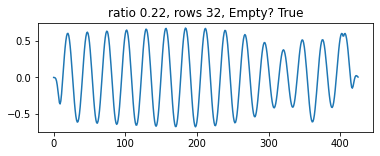

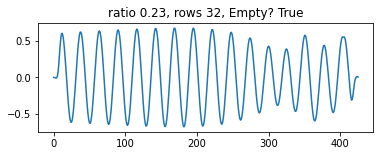

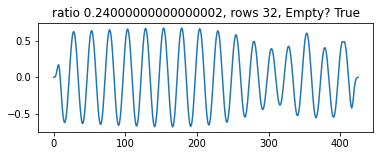

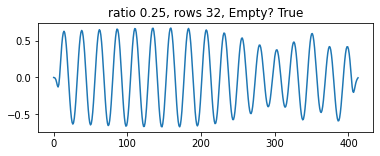

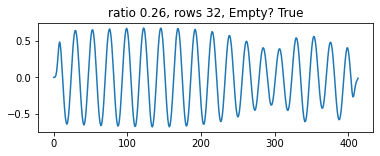

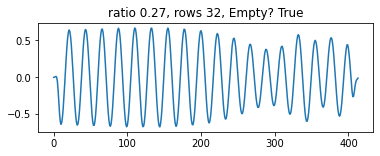

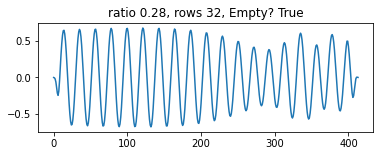

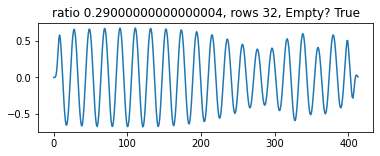

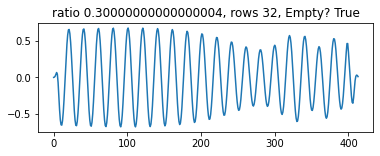

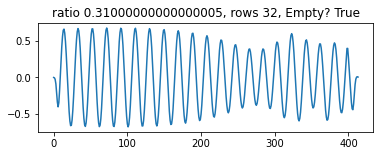

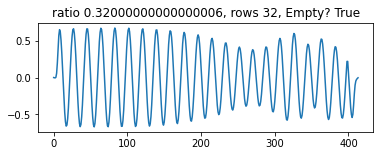

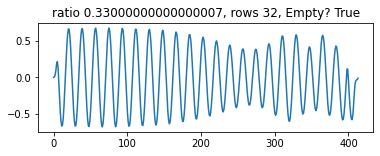

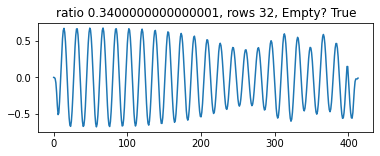

In [10]:
for (r, rows, empty_sim),result in results.items():
    if empty_sim:
        plt.figure(figsize=(6,2))
        plt.plot(result['vals'][0])
        plt.title(f'ratio {r}, rows {rows}, Empty? {empty_sim}')

In [11]:
# def run_sim(sim, get_slice, anim=False, file_outputs=False):
#     callbacks = []
#     if anim:
#         f = plt.figure()
#         anim = mp.Animate2D(sim, fields=polarization, f=f, realtime=False, normalize=True)
#         plt.close()
#         callbacks.append(mp.at_every(40,anim))
#     if file_outputs:
#         os.makedirs('outputs',exist_ok=True)
#         !rm -rf eps*h5
#         !rm -rf hz.h5
#         callbacks.append( mp.at_beginning(mp.output_epsilon) )
        
#     vals = []
#     callbacks.append(mp.at_every(499,get_slice))
#     sim.run(
#         # mp.to_appended("hz",mp.at_every(4, mp.output_hfield_z)),
#         *callbacks,
#         until=1000,
#     )
#     return vals

In [12]:
# !h5topng -t 0:125 \
# -R -Zc dkbluered \
# -a yarg \
# -A eps-000121.38.h5 hz.h5
# !h5ls hz.h5

In [13]:
# os.makedirs('media/',exist_ok=True)
# filename = f"media/r{ratio:.3f}_h{vortex_rows}_phi{90}.mp4"
# anim.to_mp4(10,filename)

In [14]:
# from IPython.display import Video
# Video(filename)